# <div align="center"> Project's Description: Scraping Komoot Website for Customized Hike Suggestions</div>

### Team Member:
- Ho Thi Hoang Nhu
- Parvin Badalov

# Outline
1. Introduction
2. Objective of Project and Dataset
3. Scraping data from website <I>(show example to understand easier ) </I>
4. Full of project: combine Scrapy, Selenium and BeautifulSoup 
5. Recommdendation System in website for user
6. Discussion

# 1. Introduction

As the digital landscape continues to reshape outdoor exploration, platforms like Komoot have become essential tools for hiking enthusiasts worldwide. With its comprehensive database of trails, terrain insights, and user-generated content, Komoot offers a treasure trove of information waiting to be harnessed. In this essay, we delve into the potential of leveraging Komoot's data to revolutionize hiking experiences. Rather than solely focusing on data analysis, our approach aims to explore the richness of Komoot's dataset and utilize it to craft personalized recommendations tailored to individual preferences and aspirations.

<div style="text-align: center;">
    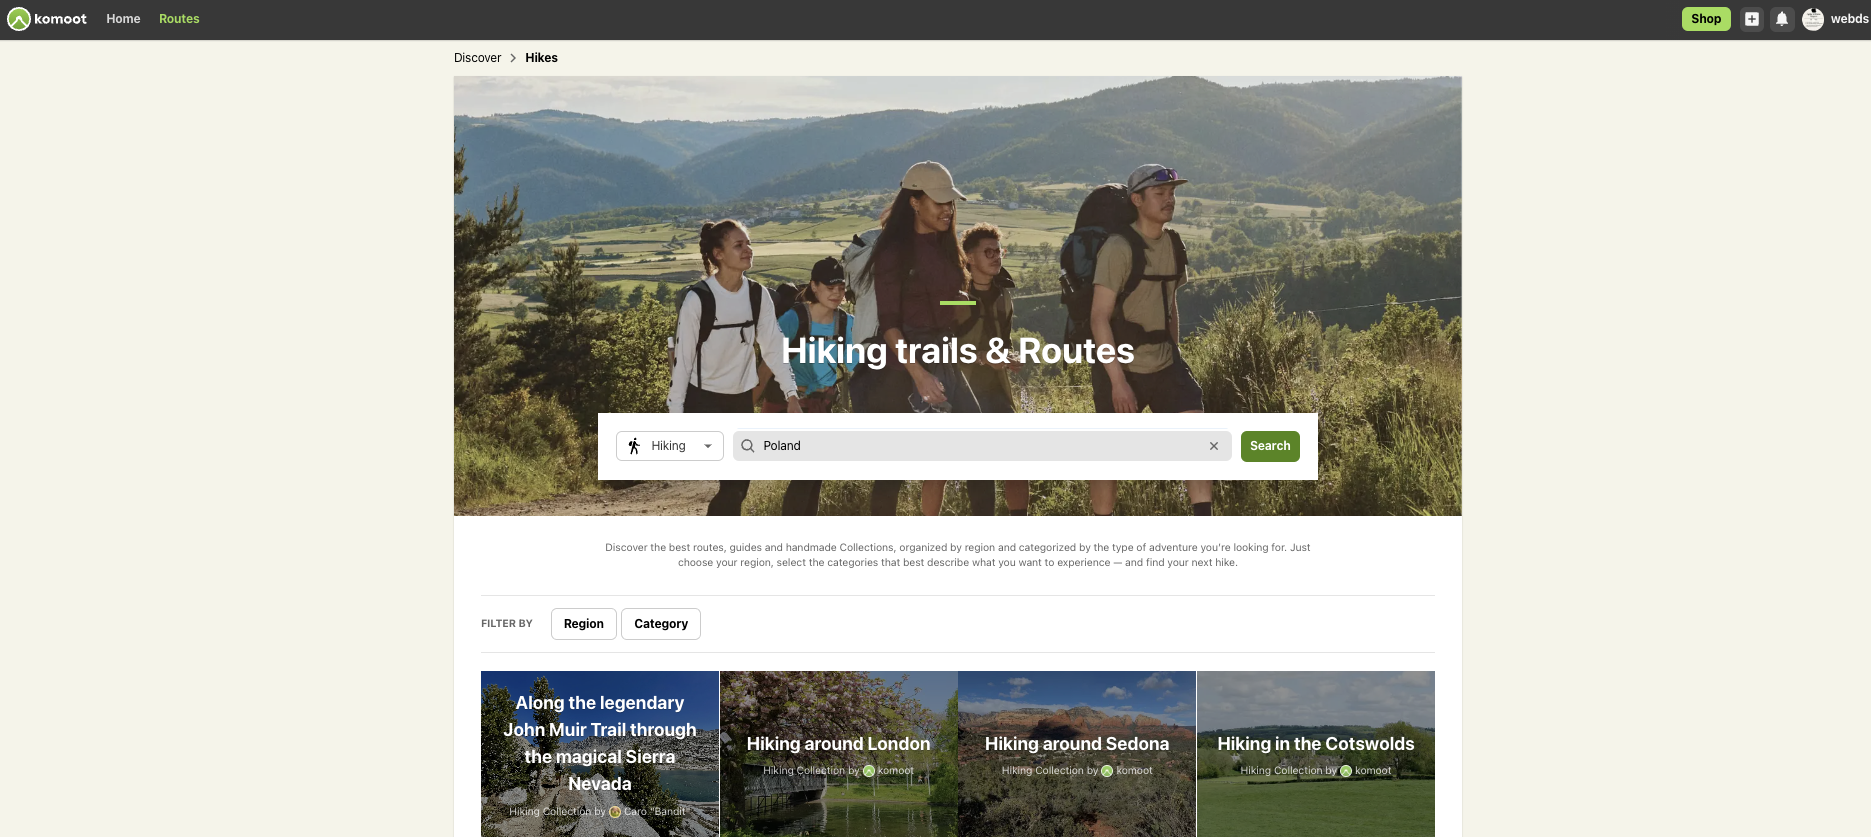
</div>



# 2. Objective of Project and Dataset:

## Objective:
The primary objective of this project is to leverage the hikes data obtained from Komoot.com to create an intelligent recommendation system for users. This system will utilize advanced data analysis techniques to understand user behaviors, preferences, and patterns when it comes to hiking. By analyzing various attributes, we aim to develop algorithms that can accurately recommend hiking trails to users based on their specific interests and requirements.

## Dataset: 
- The dataset for this project comprises a comprehensive collection of hikes data obtained from Komoot.com. 
- It includes information such as trail names, difficulty levels, ratings, duration, distance, and uphill(height). 

# 3. Scraping Data from Website

## Import Libraries

In [9]:
# import scrapy when using in python file
#import scrapy

import re #regex

import requests
import time
import pandas as pd
import numpy as np

#import sys
#sys.setrecursionlimit(10000) 

from bs4 import BeautifulSoup

import selenium
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

## Website Structure

In [10]:
url = "https://www.komoot.com/discover/Poland/@52.2159330,19.1344220/tours?sport=hike&map=true&regionId=2486&max_distance=480000&pageNumber=1"
# request for a webpage structure
webpage_html = requests.get(url) 
# text provides html only
print(webpage_html.text) 

<!doctype html>
<html lang="en" data-lang="en" class="device-desktop os-undefined fullsize c-page-index--discover fullsize">
  <head><meta http-equiv="Content-Type" content="text/html; charset=utf-8"/><script defer type="text/javascript" src="/assets/main.68957aa3.js"></script><title>Komoot Discover | Routes and Must-Sees Where You Are</title><meta name="description" content="Browse the very best the outdoors has to offer—in your area and worldwide. View MTB tracks, hikes and cycle roads, and see the most awesome must-see spots!"/><meta name="referrer" content="strict-origin-when-cross-origin"/><meta name="robots" content="noindex"/><meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=no viewport-fit=cover"/><meta property="og:image" content="https://www.komoot.com/images/og-images/og-image-default-en.png"/><meta property="og:site_name" content="komoot"/><meta property="og:title" content="Komoot Discover | Routes and Must-Sees Where You

<div style="text-align: center;">
    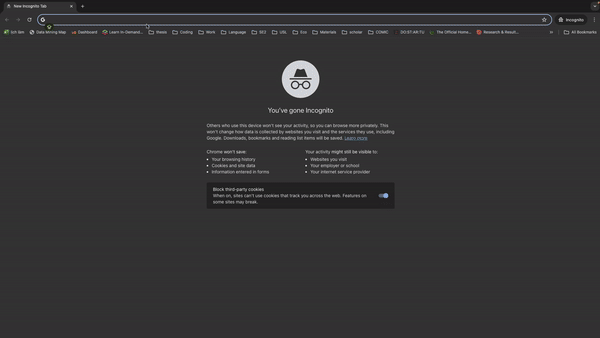
</div>

We encountered a <b>"banner"</b> on the webpage (webpage_html.text) that's obstructing our data scraping process. To circumvent this hurdle and collect the dataset, we'll employ Selenium to access the website and attempt to disable the banner.

In [11]:
chromepath = ChromeDriverManager().install() #find the Chrome path

service_chrome = Service(executable_path = chromepath) 

options_chrome = webdriver.ChromeOptions()
options_list = ["--incognito","--no-sandbox","--disable-notifications","--disable-infobars","--disable-extensions","--disable-web-security"]
for i in options_list:
    options_chrome.add_argument(i)
    
driver_chrome = webdriver.Chrome(service = service_chrome, options = options_chrome) # opens Chrome

# opens a website
driver_chrome.get(url) 


# relative Xpath of "Ok, It's fine" button for improving our experience
WebDriverWait(driver_chrome, 30).until(EC.visibility_of_element_located((By.XPATH, '''//*[@data-testid="gdpr-banner-accept"]''')))
time.sleep(np.random.chisquare(1)+3)
content = driver_chrome.find_element("xpath", '''//*[@data-testid="gdpr-banner-accept"]''') 
content.click()

To access a wider selection of hikes, we can sign in.

In [12]:
WebDriverWait(driver_chrome, 30).until(EC.visibility_of_element_located((By.XPATH, "//header/a[2]")))
time.sleep(np.random.chisquare(1)+3)
go_login = driver_chrome.find_element("xpath", "//header/a[2]") 
go_login.click()

time.sleep(1)

#login by email
login = driver_chrome.find_element("xpath", "//input[@id='email']") 
login.send_keys("mailracbalan@gmail.com")

WebDriverWait(driver_chrome, 30).until(EC.visibility_of_element_located((By.XPATH, "//body/div[@id='pageMountNode']/div[1]/div[1]/div[2]/div[1]/div[1]/form[1]/div[4]/button[1]")))
time.sleep(np.random.chisquare(1)+3)
driver_chrome.find_element("xpath", "//body/div[@id='pageMountNode']/div[1]/div[1]/div[2]/div[1]/div[1]/form[1]/div[4]/button[1]").click()

time.sleep(1)
#for password
password = driver_chrome.find_element("xpath", "//input[@id='password']")
password.send_keys("webds123")

driver_chrome.find_element("xpath", "//button[contains(text(),'Log In')]").click()

After confirming that all pages list hikes (over 1000 hikes across 84 pages), we circumvent the need to re-login on every page reset by using a loop that iterates through all 84 pages using the "Next" button.

BeautifulSoup is employed within the loop for efficient data extraction based on specific classes, offering a simpler and faster alternative to Selenium for scraping in this scenario.

In [13]:
item = {'Name': [] ,'Level': [],'Rating': [],'Duration': [],'Distance': [], 'Height': []}

for i in range(1,5):
    
    time.sleep(1)
    soup = BeautifulSoup(driver_chrome.page_source, 'html.parser')
    
    # lambda Function
    append_data = lambda elements, key: [item[key].append(element.text) for element in elements]

    # Extracting and appending data
        #names
    names = soup.find_all('strong')
    append_data(names, "Name")

        # levels
    levels = soup.find_all('div', {'class': 'css-elu0ie'})
    append_data(levels, "Level")

        # durations
    durations = soup.find_all('span', attrs={'data-test-id': 't_duration_value'})
    append_data(durations, "Duration")
    
        #rating
    ratings = soup.find_all('div', {'class': 'css-xlo6ik'})
    for element in ratings:
        match = re.search(r'css-1rt9qp4', str(element)) # use regex
        if match:  #if it's available
            item["Rating"].append(float(element.find('p', {'class': 'css-1rt9qp4'}).text)) 
        else: #if it is not in data
            item["Rating"].append(0)

        #distance
    distances = soup.find_all('span', attrs={'data-test-id': 't_distance_value'})
    for element in distances:
       item["Distance"].append(float(re.search(r'[\d.]+', element.text).group())) # use regex to find number of distance
    
        #uphill
    uphills = soup.find_all('span', attrs={'data-test-id': 't_elevation_up_value'})
    for element in uphills:
        item["Height"].append(re.search(r'([\d,]+(?:\.\d+)?)', element.text).group()) # use regex to find number of uphill

    if i == 1:
        #without 2 button -> use button[1]
        driver_chrome.find_element("xpath", "//body/div[@id='pageMountNode']/div[1]/div[3]/div[2]/div[1]/div[3]/div[1]/div[1]/div[3]/button[1]").click()
    else:
        #with 2 button -> use button[2] for clicking next page
        WebDriverWait(driver_chrome, 30).until(EC.visibility_of_element_located((By.XPATH, "/html[1]/body[1]/div[1]/div[1]/div[3]/div[2]/div[1]/div[3]/div[1]/div[1]/div[3]/button[2]")))
        time.sleep(np.random.chisquare(1)+3)
        driver_chrome.find_element("xpath", "/html[1]/body[1]/div[1]/div[1]/div[3]/div[2]/div[1]/div[3]/div[1]/div[1]/div[3]/button[2]").click() 


## Dataset

In [14]:
# apply data into dataframe
data = pd.DataFrame(item)
#show types of data
data.dtypes

Name         object
Level        object
Rating      float64
Duration     object
Distance    float64
Height       object
dtype: object

In [15]:
data

,Name,Level,Rating,Duration,Distance,Height
0,Pętla Wołosate - Tarnica - Halicz - Rozsypanie...,Expert,4.9,06:28,12.70,"2,625"
1,Pętla Wołosate - Tarnica - Szeroki Wierch - Us...,Expert,4.9,05:53,11.60,"2,275"
2,Morskie Oko – Czarny Staw loop from Tatranská ...,Expert,4.8,07:03,14.10,"1,950"
3,View of Morskie Oko – Wodogrzmoty Mickiewicza ...,Intermediate,4.8,04:44,9.88,"1,425"
4,Mal Staw See in Polen – Blick auf Maly Staw lo...,Expert,4.9,06:26,12.40,"2,850"
5,Pętla Smerek - Przełęcz Orłowicza - Wetlina: B...,Intermediate,4.7,04:39,8.91,"1,975"
6,Kirowa Woda Bridge – Schronisko na Hali Ornak ...,Expert,4.9,03:26,7.43,775
7,Pętla Ustrzyki Górne - Połonina Caryńska - Mał...,Expert,5.0,06:27,11.20,"3,400"
8,Polanka - Sine Wiry: Ciśniańsko-Wetliński Park...,Intermediate,5.0,02:09,4.70,550
9,Wetlina - Smerek (przez szlak żółty): Bieszcza...,Intermediate,5.0,03:32,6.43,"1,825"


Now we can convert some attributes from object to numeric!
- For Height, we remove the comma
- Convert Duration to hours
- Convert Level to factor

In [16]:
data['Height'] = data['Height'].apply(lambda x: x.replace(',', ''))
data['Duration'] = data['Duration'].apply(lambda x: round((int(x.split(':')[0]) + int(x.split(':')[1])/60), 2))
data['Level'] = pd.Categorical(data['Level'], categories=['Easy', 'Intermediate', 'Expert'], ordered=True)

In [18]:
data

,Name,Level,Rating,Duration,Distance,Height
0,Pętla Wołosate - Tarnica - Halicz - Rozsypanie...,Expert,4.9,6.47,12.70,2625
1,Pętla Wołosate - Tarnica - Szeroki Wierch - Us...,Expert,4.9,5.88,11.60,2275
2,Morskie Oko – Czarny Staw loop from Tatranská ...,Expert,4.8,7.05,14.10,1950
3,View of Morskie Oko – Wodogrzmoty Mickiewicza ...,Intermediate,4.8,4.73,9.88,1425
4,Mal Staw See in Polen – Blick auf Maly Staw lo...,Expert,4.9,6.43,12.40,2850
5,Pętla Smerek - Przełęcz Orłowicza - Wetlina: B...,Intermediate,4.7,4.65,8.91,1975
6,Kirowa Woda Bridge – Schronisko na Hali Ornak ...,Expert,4.9,3.43,7.43,775
7,Pętla Ustrzyki Górne - Połonina Caryńska - Mał...,Expert,5.0,6.45,11.20,3400
8,Polanka - Sine Wiry: Ciśniańsko-Wetliński Park...,Intermediate,5.0,2.15,4.70,550
9,Wetlina - Smerek (przez szlak żółty): Bieszcza...,Intermediate,5.0,3.53,6.43,1825


In [17]:
average_values_by_level = data.groupby('Level')[['Rating', 'Duration', 'Distance']].mean()

print(average_values_by_level)

                Rating  Duration   Distance
Level                                      
Easy          4.911111  1.601111   3.800000
Intermediate  4.871429  3.058571   6.125238
Expert        4.883333  6.167778  11.509444


In [ ]:
data.to_csv("recommend_web/komoot1.csv", encoding="utf-8", index=False)

# 4. Full of project: combine Scrapy, Selenium and BeautifulSoup 
In Part 3, we just show how we can crawl data from website. In this part, We run python file to collect data and build the recommendation system.

We can see in <b>hikes_scraper</b> folder! we run by command: 
<B> "scrapy crawl hiking_selenium"</B>

# 5. Recommendation System Website
#### In <b>recommendation_web</b> folder, we create simple website for users choose the name, level, duration or distance they want to prefer.

running by command: <b>"python main.py"</b>

# 6. Discussions

Exploring hiking trails on platforms like Komoot can be an exciting endeavor, offering a wealth of information and inspiration for outdoor enthusiasts. However, the process of gathering data from the website presents several challenges that can hinder the efficiency of data collection and analysis.

Firstly, one of the notable obstacles is the <b>time-consuming</b> nature of data collection. Komoot's website employs banners and scripts that impede automated data extraction, requiring manual intervention to navigate through the pages and access relevant information. This not only increases the time investment required but also adds complexity to the data collection process.

Moreover, accessing comprehensive data often <b>necessitates user authentication or login</b>. While this may enhance the quality and depth of available data, it adds another layer of complexity and time consumption to the data gathering process. Without proper authentication, access to certain features and datasets may be limited, restricting the scope of analysis and insights.

Additionally, the navigation and organization of data on Komoot's platform pose challenges for targeted data retrieval. While the platform provides a map interface for exploring hiking trails, <b>the absence of city or province-level labeling</b> makes it difficult to narrow down data searches based on specific geographical regions. This limitation necessitates alternative methods, such as manual scrolling or keyword-based searches, to identify relevant data points, further exacerbating the time and effort required for data collection.

Furthermore, <b>the need to click through individual data points to access detailed information adds to the inefficiency of the data gathering process</b>. Each click represents a manual action required to gather additional data, contributing to the overall time and resource expenditure involved in compiling a comprehensive dataset.

In conclusion, while platforms like Komoot offer valuable insights for hiking enthusiasts, the challenges associated with data collection underscore the need for efficient and streamlined approaches to gather, process, and analyze data. Overcoming barriers such as authentication requirements, navigation limitations, and manual data retrieval processes will be essential in maximizing the potential of Komoot's dataset for research and analysis purposes.